In [1]:
# Dataset class for the flow data. DO NOT EDIT.

import numpy as np
import torch
from torch.utils.data import Dataset
import os


class FlowDataset(Dataset):
    def __init__(self, num_points=16, data_dir='flow/data/', data_session='all_params_50625', mode='train'):
        data_fn = os.path.join(data_dir, 'dataset_' + data_session + '.npy')
        bc_fn = os.path.join(data_dir, 'bc_'+ data_session + '.npy')
        target = np.load(data_fn)
        inputs = np.load(bc_fn)

        # Pre-Process Data
        # replace first time step with all the boundary conditions
        # for now, hardcoded to fill in since there are 4 bc's and 17 points
        for i in range(len(inputs)):
            D = inputs[i][0]
            dpdx = inputs[i][1]
            mu = inputs[i][2]
            nu = inputs[i][3]
            for j in range(num_points+1):
                if 0 <= j < 5:
                    target[i][0][j] = D
                elif 5 <= j < 9:
                    target[i][0][j] = dpdx
                elif 9 <= j < 13:
                    target[i][0][j] = mu
                else:
                    target[i][0][j] = nu

        num_data = len(inputs)
        np.random.seed(0)
        # split the dataset inton training and test 
        test_idx = np.random.choice(num_data, num_data//5, replace=False).tolist()
        train_idx = list(set(range(num_data)) - set(test_idx))

        self.mode = mode
        if mode == 'train':
            self.data = target[train_idx,:,:].astype(np.float32)
        elif mode == 'test':
            self.data = target[test_idx,:,:].astype(np.float32)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return self.data[idx,:-1,:], self.data[idx,1:,:]
        elif self.mode == 'test':
            return self.data[idx,0,:], self.data[idx,1:,:]
    
    def __len__(self):
        return len(self.data)

In [8]:
#LSTM
import torch.nn as nn

class FlowLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(FlowLSTM, self).__init__()
        # build your model here
        # your input should be of dim (batch_size, seq_len, input_size)
        # your output should be of dim (batch_size, seq_len, input_size) as well
        # since you are predicting velocity of next step given previous one
        
        # feel free to add functions in the class if needed

        self.cells = nn.LSTMCell(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)

    # forward pass through LSTM layer
    def forward(self, x):
        '''
        input: x of dim (batch_size, 19, 17)
        '''
        if x.dim() == 2:
            x = x.unsqueeze(1)

        batch_size, seq_len,_ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size, dtype=x.dtype)
        c_t = torch.zeros(batch_size, self.hidden_size, dtype=x.dtype)

        outputs = []

        for i in range(seq_len):
            input_t = x[:, i, :]  # Take one time step at a time
            h_t, c_t = self.cells(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs.append(output.unsqueeze(1)) 
        outputs = torch.cat(outputs, dim=1)

        return outputs


    # forward pass through LSTM layer for testing
    def test(self, x):
        '''
        input: x of dim (batch_size, 17)
        '''
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        h_t = torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype)
        c_t = torch.zeros(x.size(0), self.hidden_size, dtype=x.dtype)

        outputs = []

        for i in range(0,19):
            h_t, c_t = self.cells(x, (h_t, c_t))
            output_t = self.dropout(h_t)
            output_t = self.linear(output_t)
            outputs.append(output_t.unsqueeze(1))
            x = output_t

        outputs = torch.cat(outputs, dim=1)
       
        return outputs

<>:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\DELL\AppData\Local\Temp\ipykernel_3264\2659320296.py:108: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if device is 'cpu':


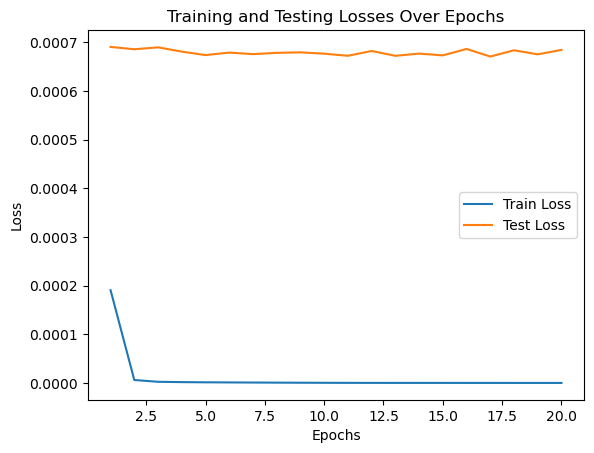

Test L1 error: 4720.359715461731
Test L2 error: 13.454593705013394


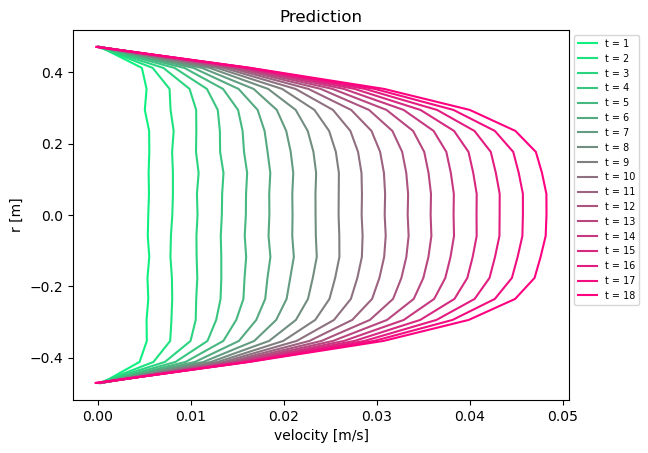

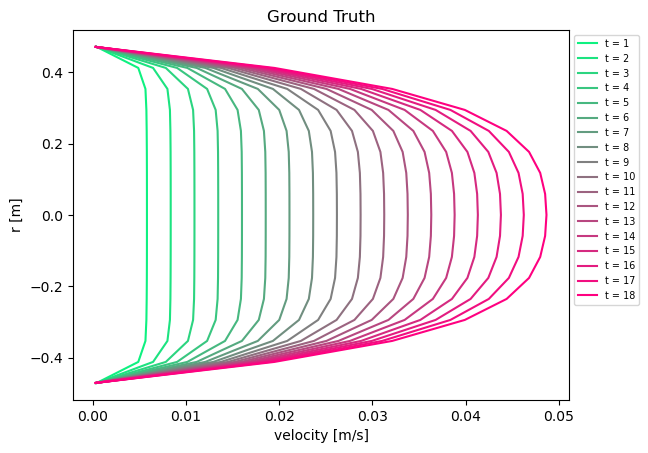

In [13]:
# Train LSTM

import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt


def main():
    # check if cuda available
    
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # hyper-parameters
    num_epochs = 20 # TODO: experiment with number of epochs
    lr = 0.0005 # TODO: Define learning rate
    input_size = 17 # do not change input size
    hidden_size = 64# TODO: define hidden size
    num_layers = 1# TODO: define number of LSTM layers
    dropout = 0.1 # TODO: experiment wiht dropout rate
    batchsize = 128 # Adjust batch size as needed
 
    # define dataset and dataloader
    train_dataset = FlowDataset(mode='train')
    test_dataset = FlowDataset(mode='test')
    train_loader = DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batchsize, shuffle=False)

    model = FlowLSTM(
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        dropout=dropout
    )


    # define your LSTM loss function here
    loss_func = nn.MSELoss()

    # define optimizer for lstm model
    optim = Adam(model.parameters(), lr=lr)

    # record and plot the test and train losses
    test_losses = []
    train_losses = []
    # Note: When plotting the loss, you may want to limit the y-axis since 
    # the training loss may be very large in the first epoch.
    for epoch in range(num_epochs):
        train_loss_total = 0.0
        model.train()
        for n_batch, (in_batch, label) in enumerate(train_loader):
            in_batch, label = in_batch, label

           # train LSTM
            pred = model(in_batch)
            # calculate LSTM loss
            # loss = loss_func(...)
            loss = loss_func(pred, label)
            optim.zero_grad()
            loss.backward()
            optim.step()
            train_loss_total +=loss.item()
        
        avg_train_loss = train_loss_total / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss_sum = 0.0
        with torch.no_grad():
            for n_batch, (in_batch, label) in enumerate(test_loader):
                in_batch, label = in_batch, label
                pred = model(in_batch)
                test_loss_sum += loss_func(pred, label).item()

        # calculate and record average test loss for the epoch
        avg_test_loss = test_loss_sum / len(test_loader)
        test_losses.append(avg_test_loss)
    
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Losses Over Epochs')
    plt.legend()
    plt.show()

    # test trained LSTM model and print out the final L1 and L2 errors
    l1_err, l2_err = 0, 0
    l1_loss = nn.L1Loss(reduction='sum')
    l2_loss = nn.MSELoss(reduction='sum')
    model.eval()
    with torch.no_grad():
        for n_batch, (in_batch, label) in enumerate(test_loader):
            in_batch, label = in_batch, label
            pred = model.test(in_batch)
            
            l1_err += l1_loss(pred, label).item()
            l2_err += l2_loss(pred, label).item()

    print("Test L1 error:", l1_err)
    print("Test L2 error:", l2_err)

    # visualize the prediction comparing to the ground truth
    if device is 'cpu':
        pred = pred.detach().numpy()[0,:,:]
        label = label.detach().numpy()[0,:,:]
    else:
        pred = pred.detach().cpu().numpy()[0,:,:]
        label = label.detach().cpu().numpy()[0,:,:]

    r = []
    num_points = 17
    interval = 1./num_points
    x = int(num_points/2)
    for j in range(-x,x+1):
        r.append(interval*j)

    plt.figure()
    for i in range(1, len(pred)):
        c = (i/(num_points+1), 1-i/(num_points+1), 0.5)
        plt.plot(pred[i], r, label='t = %s' %(i), c=c)
    plt.xlabel('velocity [m/s]')
    plt.ylabel('r [m]')
    plt.title('Prediction')
    plt.legend(bbox_to_anchor=(1,1),fontsize='x-small')
    plt.show()

    plt.figure()
    for i in range(1, len(label)):
        c = (i/(num_points+1), 1-i/(num_points+1), 0.5)
        plt.plot(label[i], r, label='t = %s' %(i), c=c)
    plt.xlabel('velocity [m/s]')
    plt.ylabel('r [m]')
    plt.title('Ground Truth')
    plt.legend(bbox_to_anchor=(1,1),fontsize='x-small')
    plt.show()


if __name__ == "__main__":
    main()

